In [0]:
# Create Spark Session
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("ECommerceAnalysis").getOrCreate()


In [0]:
# Create CSV files directly in DBFS
csv_customers = """customer_id,name,city,age
1,Rahul Sharma,Bangalore,28
2,Priya Singh,Delhi,32
3,Aman Kumar,Hyderabad,25
4,Sneha Reddy,Chennai,35
5,Arjun Mehta,Mumbai,30
6,Divya Nair,Delhi,29
"""

csv_products = """product_id,product_name,category,price
101,Laptop,Electronics,55000
102,Mobile,Electronics,25000
103,Headphones,Electronics,3000
104,Chair,Furniture,5000
105,Book,Stationery,700
106,Shoes,Fashion,2500
"""

csv_orders = """order_id,customer_id,product_id,quantity,order_date
1001,1,101,1,2024-01-10
1002,2,102,2,2024-01-12
1003,1,103,3,2024-02-05
1004,3,104,1,2024-02-08
1005,5,105,5,2024-03-01
1006,6,106,2,2024-03-15
1007,7,101,1,2024-03-20
"""

# Upload files to DBFS
dbutils.fs.put("/FileStore/tables/customers.csv", csv_customers, True)
dbutils.fs.put("/FileStore/tables/products.csv", csv_products, True)
dbutils.fs.put("/FileStore/tables/orders.csv", csv_orders, True)


Wrote 174 bytes.
Wrote 201 bytes.
Wrote 220 bytes.


True

In [0]:
# Read CSV files into DataFrames
customers_df = spark.read.csv("/FileStore/tables/customers.csv", header=True, inferSchema=True)
products_df = spark.read.csv("/FileStore/tables/products.csv", header=True, inferSchema=True)
orders_df = spark.read.csv("/FileStore/tables/orders.csv", header=True, inferSchema=True)

# Display all three DataFrames
display(customers_df)
display(products_df)
display(orders_df)


customer_id,name,city,age
1,Rahul Sharma,Bangalore,28
2,Priya Singh,Delhi,32
3,Aman Kumar,Hyderabad,25
4,Sneha Reddy,Chennai,35
5,Arjun Mehta,Mumbai,30
6,Divya Nair,Delhi,29


product_id,product_name,category,price
101,Laptop,Electronics,55000
102,Mobile,Electronics,25000
103,Headphones,Electronics,3000
104,Chair,Furniture,5000
105,Book,Stationery,700
106,Shoes,Fashion,2500


order_id,customer_id,product_id,quantity,order_date
1001,1,101,1,2024-01-10
1002,2,102,2,2024-01-12
1003,1,103,3,2024-02-05
1004,3,104,1,2024-02-08
1005,5,105,5,2024-03-01
1006,6,106,2,2024-03-15
1007,7,101,1,2024-03-20


In [0]:
# Add total_price column and extract month from order_date
from pyspark.sql.functions import col, month, to_date

# Join orders and products to access price
joined_df = orders_df.join(products_df, on="product_id", how="left")

# Add new columns: total_price and order_month
orders_total_df = joined_df.withColumn("total_price", col("quantity") * col("price")) \
                           .withColumn("order_date", to_date(col("order_date"), "yyyy-MM-dd")) \
                           .withColumn("order_month", month(col("order_date")))

# Display the updated DataFrame
display(orders_total_df.select("order_id","customer_id","product_id","product_name","quantity","price","total_price","order_date","order_month"))


order_id,customer_id,product_id,product_name,quantity,price,total_price,order_date,order_month
1001,1,101,Laptop,1,55000,55000,2024-01-10,1
1002,2,102,Mobile,2,25000,50000,2024-01-12,1
1003,1,103,Headphones,3,3000,9000,2024-02-05,2
1004,3,104,Chair,1,5000,5000,2024-02-08,2
1005,5,105,Book,5,700,3500,2024-03-01,3
1006,6,106,Shoes,2,2500,5000,2024-03-15,3
1007,7,101,Laptop,1,55000,55000,2024-03-20,3


In [0]:
# Filter orders above 40,000 and sort descending
high_value_orders = orders_total_df.filter(col("total_price") > 40000).orderBy(col("total_price").desc())
display(high_value_orders)


product_id,order_id,customer_id,quantity,order_date,product_name,category,price,total_price,order_month
101,1001,1,1,2024-01-10,Laptop,Electronics,55000,55000,1
101,1007,7,1,2024-03-20,Laptop,Electronics,55000,55000,3
102,1002,2,2,2024-01-12,Mobile,Electronics,25000,50000,1


In [0]:
# Aggregations

# Join orders with customers to include city info
orders_products = orders_total_df
orders_with_customers = orders_products.join(customers_df, on="customer_id", how="left")

# Total revenue per city
revenue_per_city = orders_with_customers.groupBy("city").sum("total_price").withColumnRenamed("sum(total_price)", "total_revenue")
display(revenue_per_city)

# Average age of customers per city
avg_age_per_city = customers_df.groupBy("city").avg("age").withColumnRenamed("avg(age)", "avg_age")
display(avg_age_per_city)

# Total revenue per category
revenue_per_category = orders_products.groupBy("category").sum("total_price").withColumnRenamed("sum(total_price)", "total_revenue")
display(revenue_per_category)

# Top 3 customers by total spending
spending_per_customer = orders_with_customers.groupBy("customer_id","name").sum("total_price") \
                      .withColumnRenamed("sum(total_price)","total_spent") \
                      .orderBy(col("total_spent").desc())
display(spending_per_customer.limit(3))


city,total_revenue
null,55000
Bangalore,64000
Delhi,55000
Mumbai,3500
Hyderabad,5000


city,avg_age
Bangalore,28.0
Chennai,35.0
Delhi,30.5
Mumbai,30.0
Hyderabad,25.0


category,total_revenue
Electronics,169000
Furniture,5000
Stationery,3500
Fashion,5000


customer_id,name,total_spent
1,Rahul Sharma,64000
7,null,55000
2,Priya Singh,50000


In [0]:
# Different types of joins and identifying missing records

# Inner Join (orders + customers)
inner_orders_customers = orders_df.join(customers_df, on="customer_id", how="inner")

# Left Join (customers + orders)
left_customers_orders  = customers_df.join(orders_df, on="customer_id", how="left")

# Right Join (orders + products)
right_orders_products  = orders_df.join(products_df, on="product_id", how="right")

# Display results
display(inner_orders_customers)
display(left_customers_orders)
display(right_orders_products)

# Customers with no orders
customers_with_orders = orders_df.select("customer_id").distinct()
customers_no_orders = customers_df.join(customers_with_orders, on="customer_id", how="left_anti")
display(customers_no_orders)

# Products that were never ordered
products_ordered = orders_df.select("product_id").distinct()
products_never_ordered = products_df.join(products_ordered, on="product_id", how="left_anti")
display(products_never_ordered)


customer_id,order_id,product_id,quantity,order_date,name,city,age
1,1001,101,1,2024-01-10,Rahul Sharma,Bangalore,28
2,1002,102,2,2024-01-12,Priya Singh,Delhi,32
1,1003,103,3,2024-02-05,Rahul Sharma,Bangalore,28
3,1004,104,1,2024-02-08,Aman Kumar,Hyderabad,25
5,1005,105,5,2024-03-01,Arjun Mehta,Mumbai,30
6,1006,106,2,2024-03-15,Divya Nair,Delhi,29


customer_id,name,city,age,order_id,product_id,quantity,order_date
1,Rahul Sharma,Bangalore,28,1003,103,3,2024-02-05
4,Sneha Reddy,Chennai,35,null,null,null,null
6,Divya Nair,Delhi,29,1006,106,2,2024-03-15
3,Aman Kumar,Hyderabad,25,1004,104,1,2024-02-08
2,Priya Singh,Delhi,32,1002,102,2,2024-01-12
5,Arjun Mehta,Mumbai,30,1005,105,5,2024-03-01
1,Rahul Sharma,Bangalore,28,1001,101,1,2024-01-10


product_id,order_id,customer_id,quantity,order_date,product_name,category,price
102,1002,2,2,2024-01-12,Mobile,Electronics,25000
101,1007,7,1,2024-03-20,Laptop,Electronics,55000
104,1004,3,1,2024-02-08,Chair,Furniture,5000
103,1003,1,3,2024-02-05,Headphones,Electronics,3000
105,1005,5,5,2024-03-01,Book,Stationery,700
106,1006,6,2,2024-03-15,Shoes,Fashion,2500
101,1001,1,1,2024-01-10,Laptop,Electronics,55000


customer_id,name,city,age
4,Sneha Reddy,Chennai,35


product_id,product_name,category,price


In [0]:
# Create Temporary SQL Views
customers_df.createOrReplaceTempView("customers")
products_df.createOrReplaceTempView("products")
orders_total_df.createOrReplaceTempView("orders")


In [0]:
%sql
-- Top 2 cities by total revenue

SELECT c.city, SUM(o.total_price) AS total_revenue
FROM orders o
JOIN customers c ON o.customer_id = c.customer_id
GROUP BY c.city
ORDER BY total_revenue DESC
LIMIT 2;


city,total_revenue
Bangalore,64000
Delhi,55000


In [0]:
%sql
--  Most popular category by revenue

SELECT p.category, SUM(o.total_price) AS revenue
FROM orders o
JOIN products p ON o.product_id = p.product_id
GROUP BY p.category
ORDER BY revenue DESC
LIMIT 1;


category,revenue
Electronics,169000


In [0]:
%sql
-- Customers who spent more than 50,000

SELECT o.customer_id, c.name, SUM(o.total_price) AS total_spent
FROM orders o
JOIN customers c ON o.customer_id = c.customer_id
GROUP BY o.customer_id, c.name
HAVING SUM(o.total_price) > 50000
ORDER BY total_spent DESC;


customer_id,name,total_spent
1,Rahul Sharma,64000


In [0]:
%sql
-- Monthly sales trend

SELECT month(order_date) AS month, SUM(total_price) AS monthly_revenue
FROM orders
GROUP BY month
ORDER BY month;


month,monthly_revenue
1,105000
2,14000
3,63500


In [0]:
# Save and read back the summary DataFrame
orders_total_df.write.mode("overwrite").option("header", True).csv("/FileStore/tables/orders_summary")

# List saved files
display(dbutils.fs.ls("/FileStore/tables/orders_summary"))

# Read back the saved CSV
summary_df = spark.read.csv("/FileStore/tables/orders_summary", header=True, inferSchema=True)
display(summary_df)


path,name,size,modificationTime
dbfs:/FileStore/tables/orders_summary/_SUCCESS,_SUCCESS,0,1759845011000
dbfs:/FileStore/tables/orders_summary/_committed_4332621355902353409,_committed_4332621355902353409,113,1759845011000
dbfs:/FileStore/tables/orders_summary/_started_4332621355902353409,_started_4332621355902353409,0,1759845011000
dbfs:/FileStore/tables/orders_summary/part-00000-tid-4332621355902353409-81d119ca-065e-4f92-9b47-12d4439a4ace-184-1-c000.csv,part-00000-tid-4332621355902353409-81d119ca-065e-4f92-9b47-12d4439a4ace-184-1-c000.csv,487,1759845011000


product_id,order_id,customer_id,quantity,order_date,product_name,category,price,total_price,order_month
101,1001,1,1,2024-01-10,Laptop,Electronics,55000,55000,1
102,1002,2,2,2024-01-12,Mobile,Electronics,25000,50000,1
103,1003,1,3,2024-02-05,Headphones,Electronics,3000,9000,2
104,1004,3,1,2024-02-08,Chair,Furniture,5000,5000,2
105,1005,5,5,2024-03-01,Book,Stationery,700,3500,3
106,1006,6,2,2024-03-15,Shoes,Fashion,2500,5000,3
101,1007,7,1,2024-03-20,Laptop,Electronics,55000,55000,3


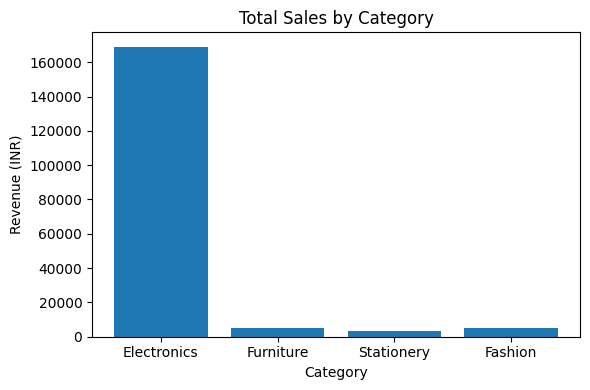

In [0]:
# Visualization (Matplotlib)
import matplotlib.pyplot as plt

# Group total sales by category
category_df = orders_products.groupBy("category").sum("total_price").withColumnRenamed("sum(total_price)","revenue")
p_cat = category_df.toPandas()

# Plot total revenue by category
plt.figure(figsize=(6,4))
plt.bar(p_cat["category"], p_cat["revenue"])
plt.title("Total Sales by Category")
plt.xlabel("Category")
plt.ylabel("Revenue (INR)")
plt.tight_layout()
plt.show()


In [0]:
# Check for missing customers or products
orders_missing_customer = orders_df.join(customers_df, on="customer_id", how="left_anti")
display(orders_missing_customer)

orders_missing_product = orders_df.join(products_df, on="product_id", how="left_anti")
display(orders_missing_product)


customer_id,order_id,product_id,quantity,order_date
7,1007,101,1,2024-03-20


product_id,order_id,customer_id,quantity,order_date
